In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import matplotlib.pyplot as plt
import datetime
from scipy.stats import randint

In [4]:
STOCK_TICKER = "TSLA"
PERIOD = "5y"
INTERVAL = "1d"
PREDICTION_DAYS = 1

In [5]:
def fetch_stock_data(ticker, period, interval):
    print(f"Fetching historical data for {ticker} over {period} with {interval} interval...")
    try:
        stock_data = yf.download(ticker, period=period, interval=interval)
        if stock_data.empty:
            print(f"No data found for {ticker} with the specified period/interval. Please check the ticker or parameters.")
        else:
            print(f"Successfully fetched {len(stock_data)} data points.")
        return stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

In [6]:
def create_features(df):
    print("Creating engineered features...")
    df_copy = df.copy()
    
    df_copy['SMA_5'] = df_copy['Close'].rolling(window=5).mean()
    df_copy['SMA_20'] = df_copy['Close'].rolling(window=20).mean()
    
    df_copy['EMA_12'] = df_copy['Close'].ewm(span=12, adjust=False).mean()
    df_copy['EMA_26'] = df_copy['Close'].ewm(span=26, adjust=False).mean()
    
    df_copy['MACD'] = df_copy['EMA_12'] - df_copy['EMA_26']
    df_copy['Signal_Line'] = df_copy['MACD'].ewm(span=9, adjust=False).mean()
    
    delta = df_copy['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    
    rs = avg_gain / avg_loss
    df_copy['RSI'] = 100 - (100 / (1 + rs))

    df_copy['Volatility'] = df_copy['Close'].pct_change().rolling(window=20).std()
    
    df_copy['Daily_Return'] = df_copy['Close'].pct_change()

    df_copy['Prev_Close'] = df_copy['Close'].shift(1)
    df_copy['Prev_Volume'] = df_copy['Volume'].shift(1)

    print("Features created successfully.")
    return df_copy

In [7]:
def define_target(df, prediction_days = 1):
    print(f"Defining target variable: predicting 'Close' price {prediction_days} day(s) into the future.")
    df['Target'] = df['Close'].shift(-prediction_days)
    print("Target variable defined.")
    return df

In [8]:
def prepare_data_for_ml(df, features_to_use, prediction_days):
    print("Preparing data for machine learning...")
    df_cleaned = df.dropna()
    if df_cleaned.empty:
        print("After cleaning, the DataFrame is empty. Not enough data for training.")
        return pd.DataFrame(), pd.Series()
    X = df_cleaned[features_to_use]
    y = df_cleaned['Target']
    print(f"Data prepared. X shape: {X.shape}, y shape: {y.shape}")
    return X, y

In [9]:
def train_and_predict(X, y):
    print("Training the machine learning model...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Model training complete.")
    return model, X_test, y_test, y_pred

In [10]:
def evaluate_model(y_test, y_pred):
    print("Evaluating model performance...")
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    print("Evaluation complete.")

In [11]:
def plot_predictions(y_test, y_pred, ticker):
    print("Generating plot of actual vs. predicted prices...")
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Close Price', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Close Price', color='red', linestyle='--')
    plt.title(f'{ticker} Stock Price Prediction (Actual vs. Predicted)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Plot displayed.")

Starting Stock Price Analysis Project for TSLA...
Fetching historical data for TSLA over 5y with 1d interval...


/var/folders/46/n9s1b9650h3fghkjcgrxmyy80000gn/T/ipykernel_3811/3341002646.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


Successfully fetched 1255 data points.
Creating engineered features...
Features created successfully.
Defining target variable: predicting 'Close' price 1 day(s) into the future.
Target variable defined.
Preparing data for machine learning...
Data prepared. X shape: (1234, 12), y shape: (1234,)
Training the machine learning model...
Model training complete.
Evaluating model performance...
Root Mean Squared Error (RMSE): 26.10
R-squared (R2): 0.86
Evaluation complete.
Generating plot of actual vs. predicted prices...


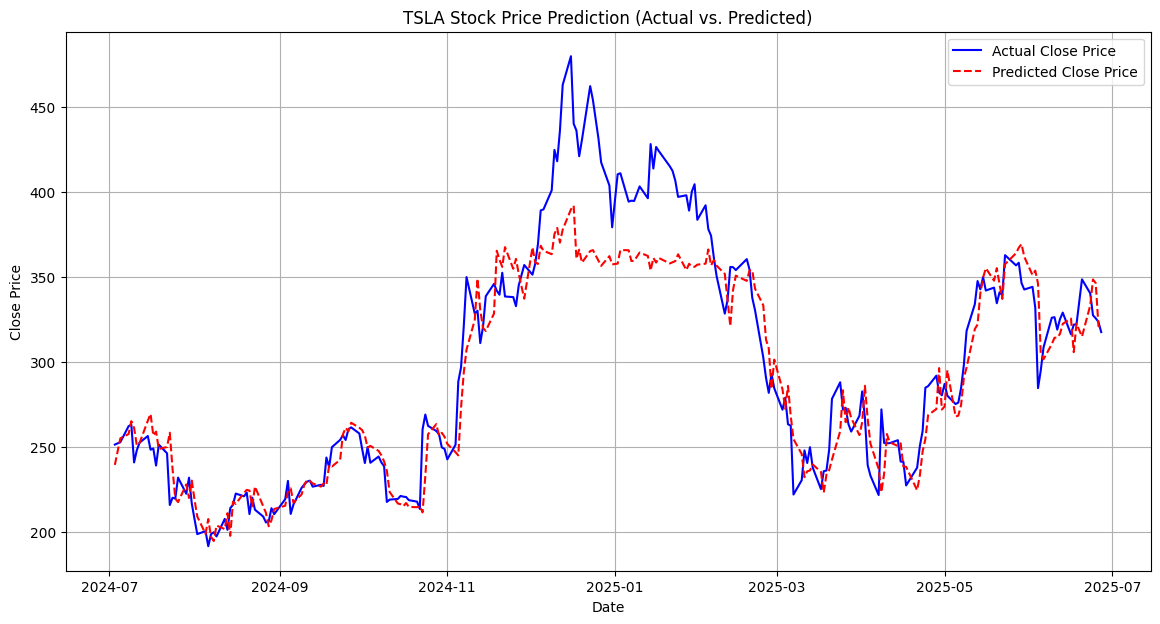

Plot displayed.

--- Predicting the next trading day's closing price ---
Predicted closing price for the next trading day: 320.20
Project for TSLA completed.


In [12]:
if __name__ == "__main__":
    print(f"Starting Stock Price Analysis Project for {STOCK_TICKER}...")
    stock_df = fetch_stock_data(STOCK_TICKER, PERIOD, INTERVAL)
    if not stock_df.empty:
        stock_df = create_features(stock_df)
        stock_df = define_target(stock_df, PREDICTION_DAYS)
        features_to_use = [
            'Volume', 'SMA_5', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line',
            'RSI', 'Volatility', 'Daily_Return', 'Prev_Close', 'Prev_Volume'
        ]
        X, y = prepare_data_for_ml(stock_df, features_to_use, PREDICTION_DAYS)
        if not X.empty and not y.empty:
            model, X_test, y_test, y_pred = train_and_predict(X, y)
            evaluate_model(y_test, y_pred)
            plot_predictions(y_test, y_pred, STOCK_TICKER)
            print("\n--- Predicting the next trading day's closing price ---")
            last_day_data = stock_df.iloc[-PREDICTION_DAYS - 1:-PREDICTION_DAYS][features_to_use]
            if not last_day_data.empty and not last_day_data.isnull().values.any():
                next_day_prediction = model.predict(last_day_data)
                print(f"Predicted closing price for the next trading day: {next_day_prediction[0]:.2f}")
            else:
                print("Could not make a prediction for the next trading day. Ensure enough recent data and no NaNs.")
print(f"Project for {STOCK_TICKER} completed.")